In [110]:
import pandas as pd
import shap
import numpy as np
import pickle

# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import IsolationForest

In [120]:
data = pd.read_parquet('20221007_CC_AD_DATA.parquet', engine='fastparquet')

describe and visualize data

         a1_curr_act    a2_curr_act    a3_curr_act    a4_curr_act  \
count  579989.000000  579989.000000  579989.000000  579989.000000   
mean        0.140691       0.396254      -0.325356      -0.110634   
std         1.970987       1.304368       1.159116       1.684823   
min       -38.457120     -17.689250     -62.524630     -62.544710   
25%        -0.029017       0.039265      -0.375184      -0.373921   
50%        -0.019487       0.072221      -0.338790       0.302395   
75%         0.193635       0.143750      -0.092842       0.392763   
max        40.614080      75.961560      70.755100      44.209050   

         a5_curr_act  a6_curr_act   a1_fol_error   a2_fol_error  \
count  579989.000000     579989.0  579989.000000  579989.000000   
mean       -0.009901          0.0      -0.000242       0.000076   
std         2.297570          0.0       0.107112       0.106951   
min       -45.797680          0.0      -1.686261      -1.554926   
25%        -0.567184          0.0       0.0

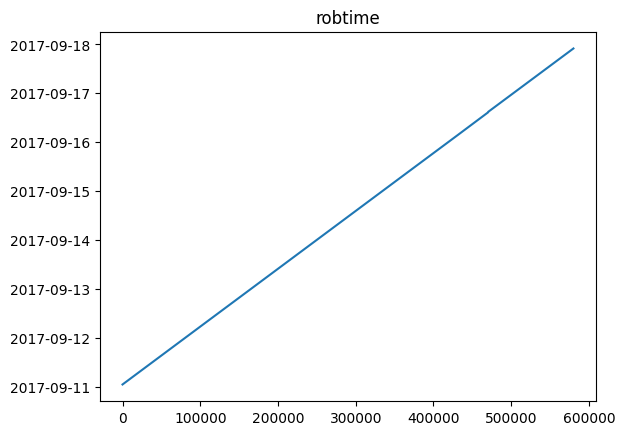

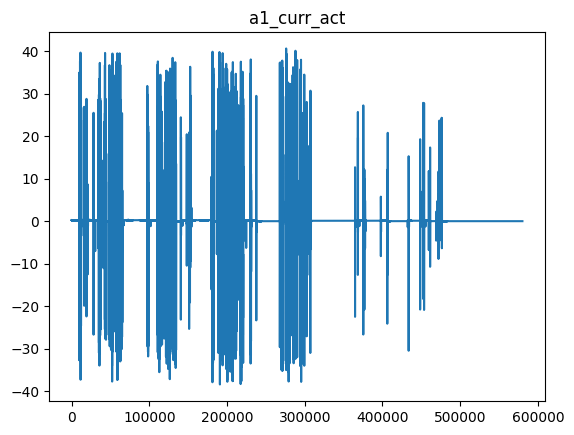

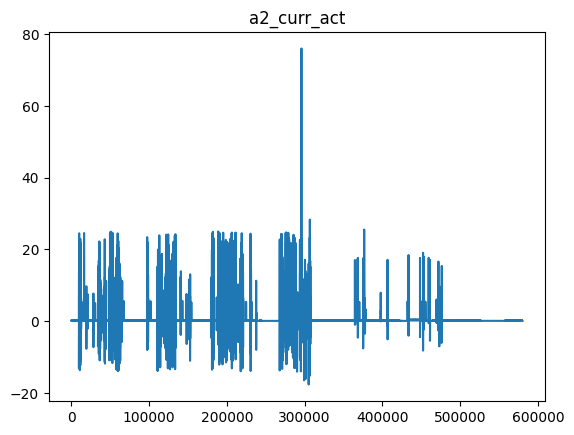

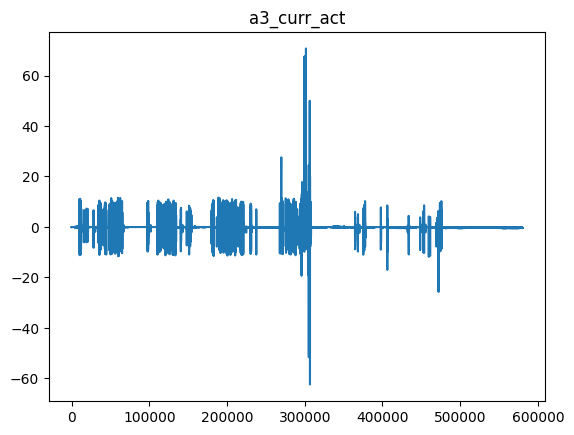

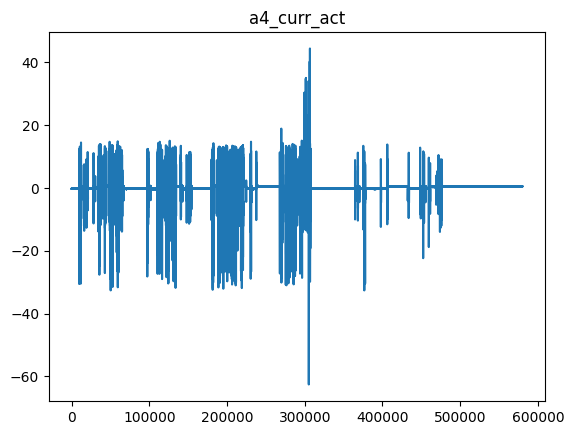

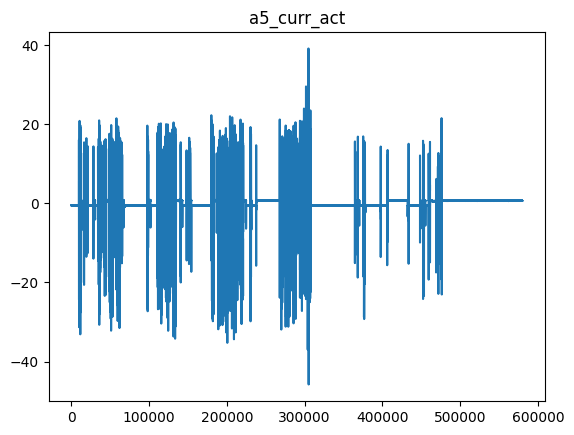

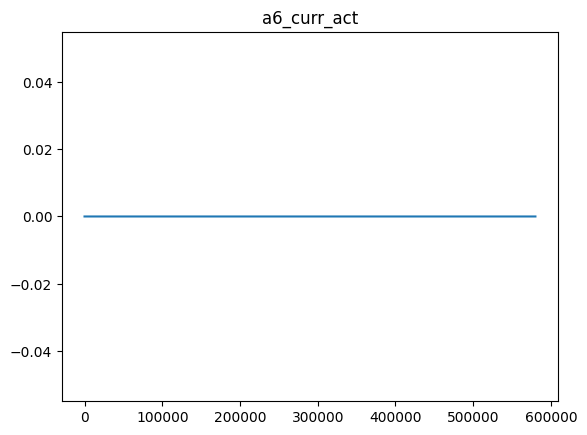

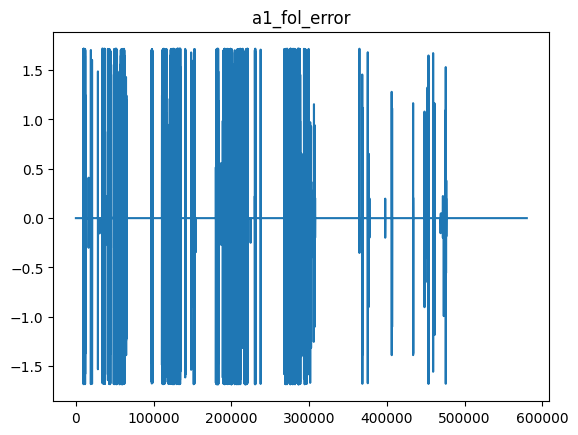

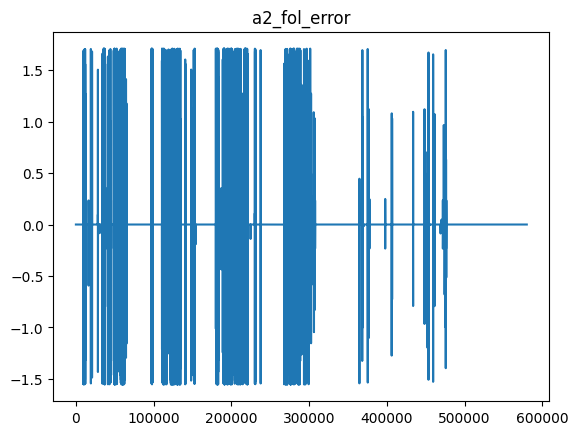

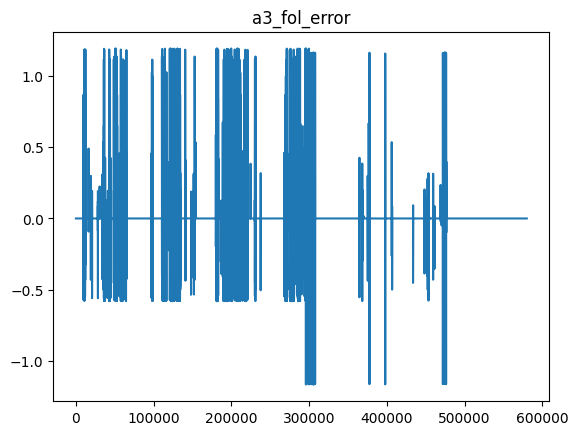

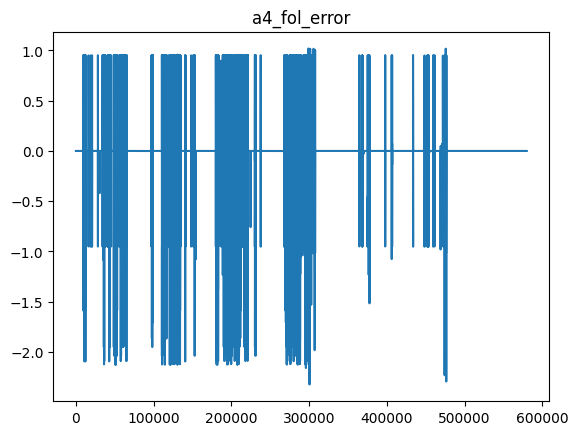

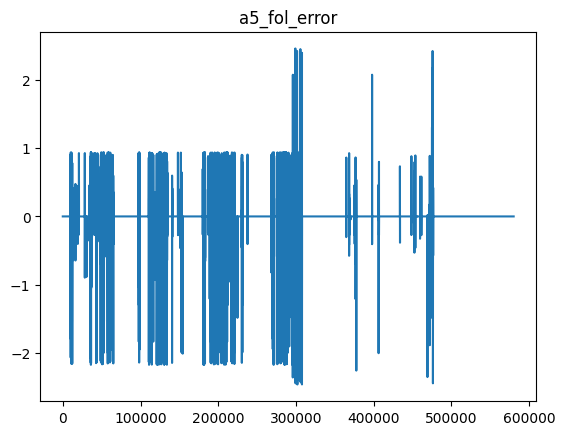

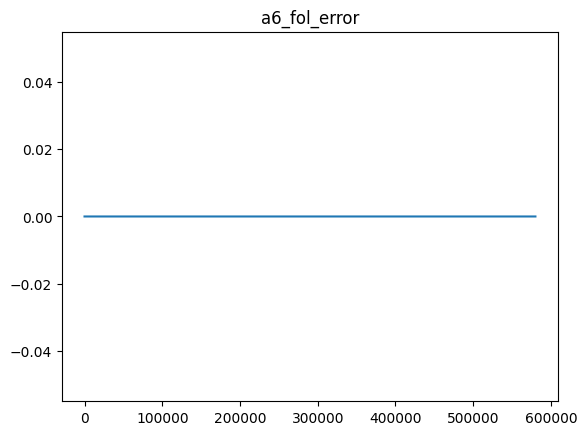

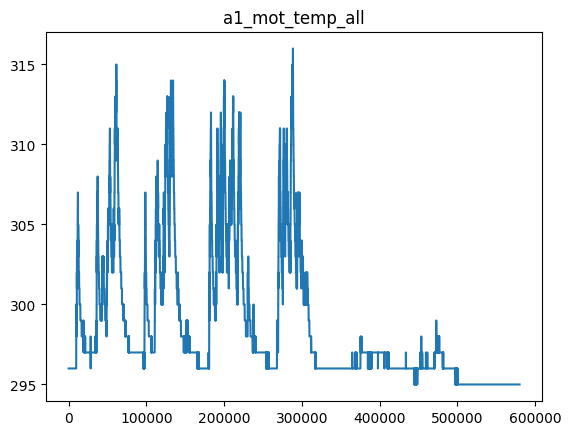

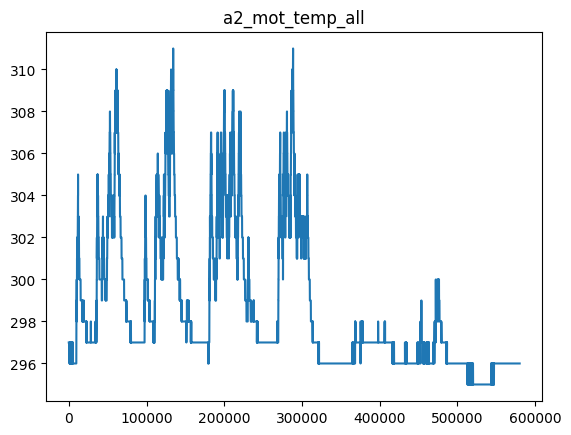

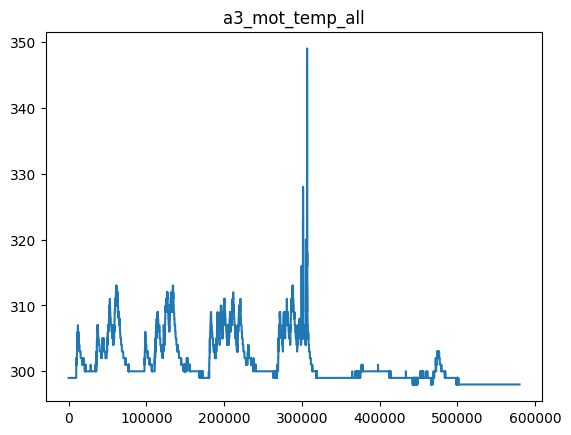

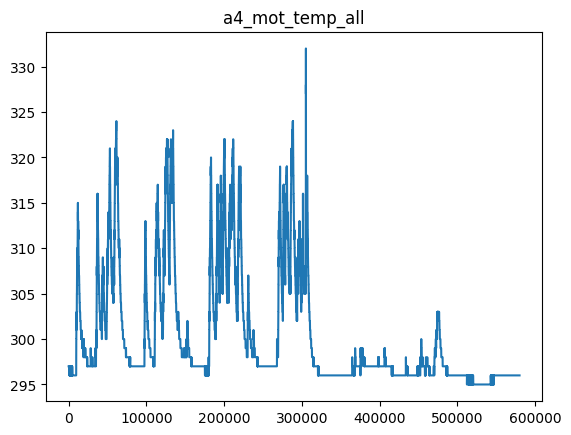

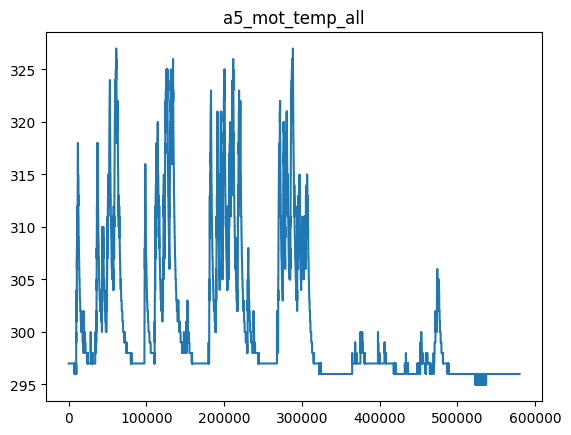

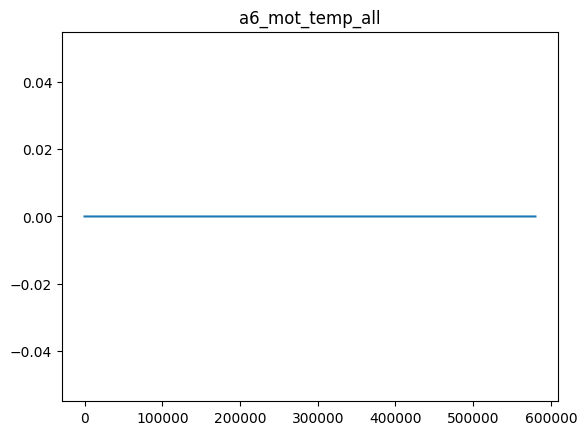

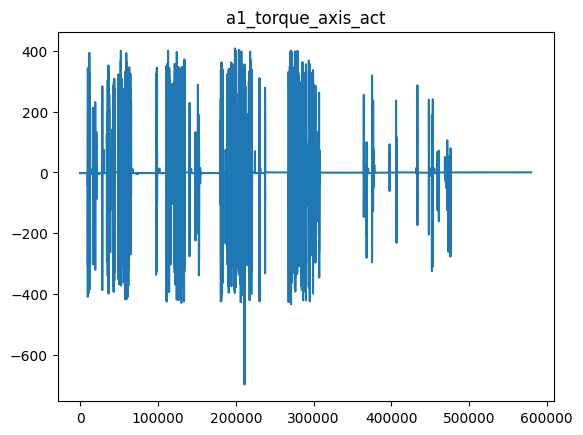

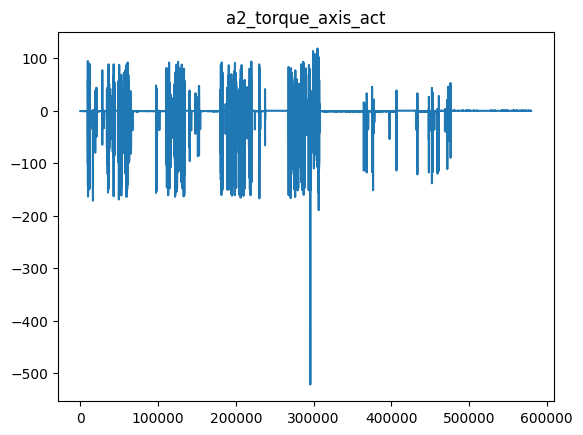

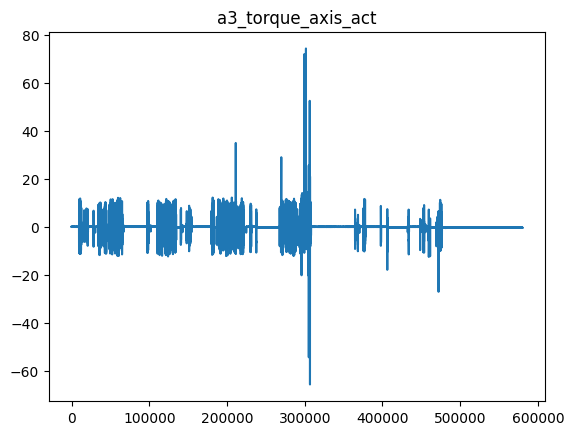

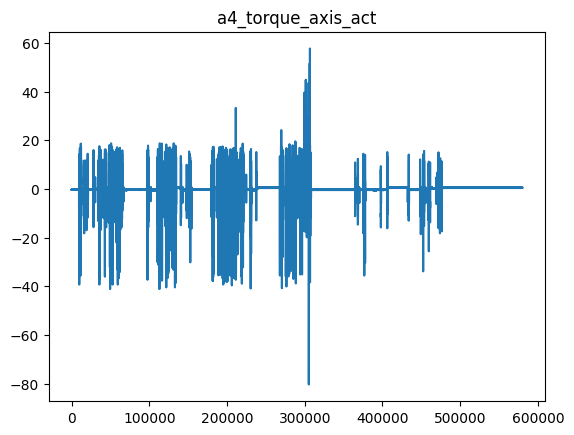

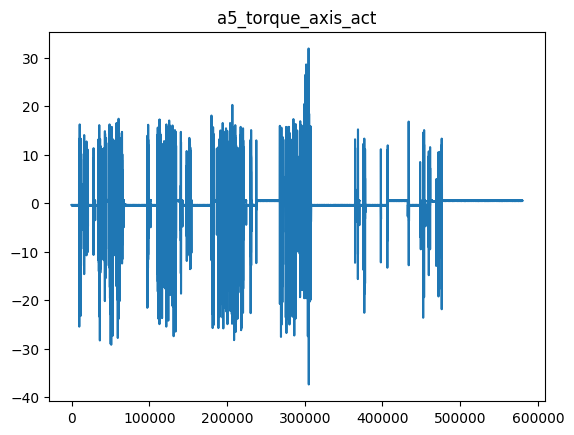

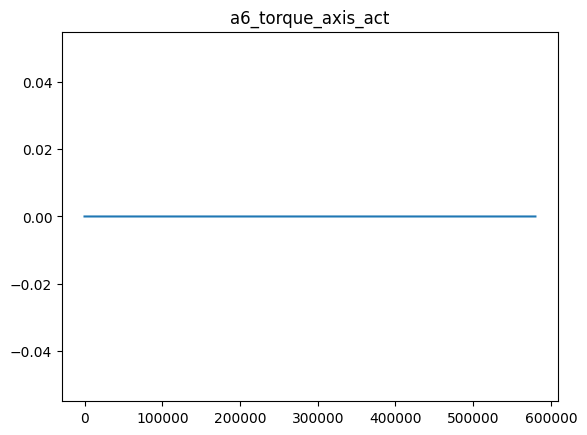

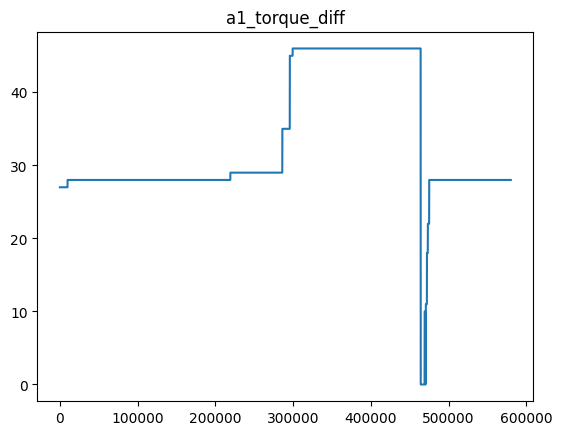

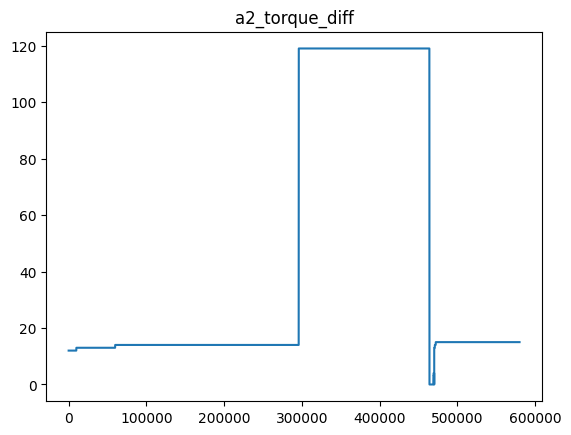

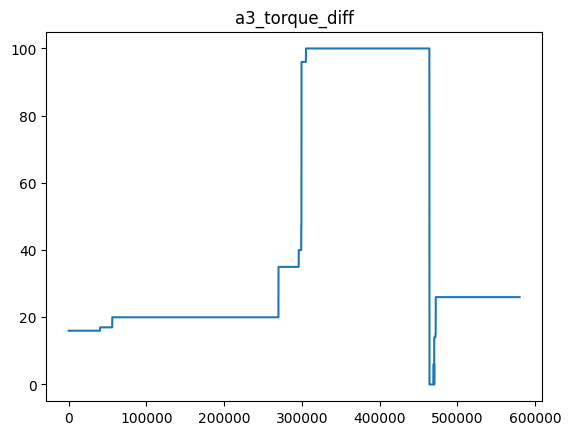

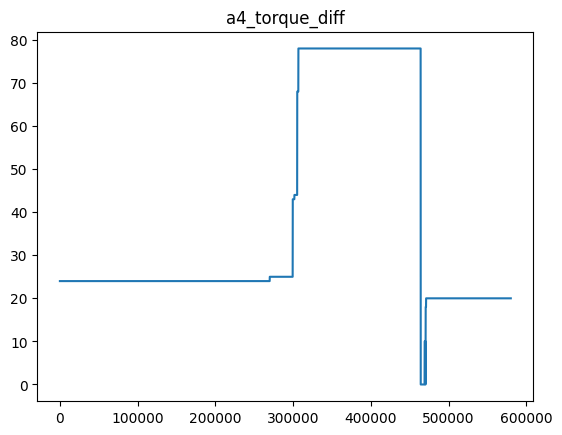

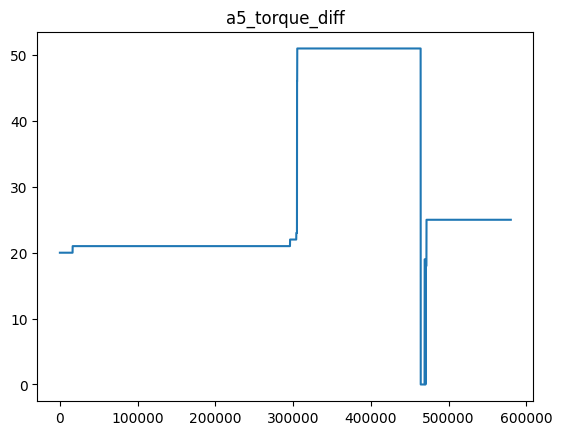

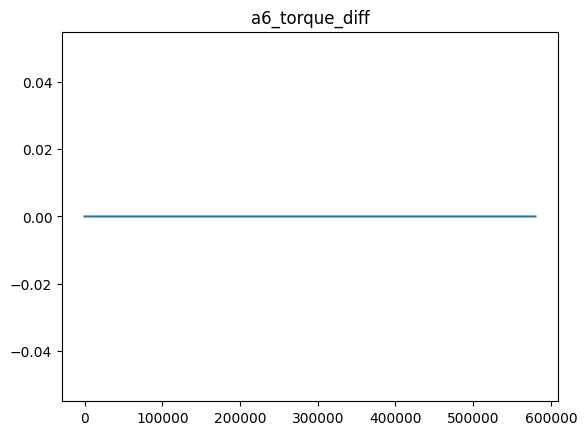

In [112]:
print(data.describe())
# plot each column as time series
for col in data.columns:
    plt.plot(data[col])
    plt.title(col)
    plt.show()

remove a6 as it contains no valuable information.
after train test split remove robtime also

In [122]:
# remove a6
data = data.drop([col for col in data.columns if col.startswith('a6')], axis=1)
print(len(data.columns))
print(data.columns)

26
Index(['robtime', 'a1_curr_act', 'a2_curr_act', 'a3_curr_act', 'a4_curr_act',
       'a5_curr_act', 'a1_fol_error', 'a2_fol_error', 'a3_fol_error',
       'a4_fol_error', 'a5_fol_error', 'a1_mot_temp_all', 'a2_mot_temp_all',
       'a3_mot_temp_all', 'a4_mot_temp_all', 'a5_mot_temp_all',
       'a1_torque_axis_act', 'a2_torque_axis_act', 'a3_torque_axis_act',
       'a4_torque_axis_act', 'a5_torque_axis_act', 'a1_torque_diff',
       'a2_torque_diff', 'a3_torque_diff', 'a4_torque_diff', 'a5_torque_diff'],
      dtype='object')


In [123]:
# train test split: 2017-09-11 are training data, the rest are testing data
train = data[data.loc[:,'robtime'] < '2017-09-12']
test = data[data.loc[:,'robtime'] < '2017-09-12']

In [128]:
# drop column robtime as not useful for anomaly detection
train = train.drop(['robtime'], axis=1)
test = test.drop(['robtime'], axis=1)

# isolation forest

In [5]:
# anomaly detection with isolation forest (scikit-learn)
# when a forest of random trees collectively produce shorter path lengths for particular samples,
# they are highly likely to be anomalies.

# train
clf1 = IsolationForest(random_state=0).fit(train)
print(clf1)

IsolationForest(random_state=0)


In [6]:
pred = clf1.predict(test)
pred

array([1, 1, 1, ..., 1, 1, 1])

In [7]:
# calculate the Anomaly Score.
# A positive score shows a normal point, whereas a negative score represents an Anomalous point.
isofor_score = clf1.decision_function(test)
isofor_score

array([0.05912635, 0.06415811, 0.03868517, ..., 0.09780717, 0.09247761,
       0.10765776])

In [8]:
# find the points that have been predicted/marked as anomalous
neg_value_indices = np.where(isofor_score<0)
print('n anomalies:', len(neg_value_indices[0]), '\nfrac anomalies:', len(neg_value_indices[0])/len(test))

n anomalies: 8115 
frac anomalies: 0.10028794938022913


In [9]:
# Tree Explainer
# create an explainer object
explainer = shap.TreeExplainer(clf1, data=train)
explainer

In [10]:
# calculate shap values
shapvs = explainer.shap_values(train, check_additivity=False)  # check should be default
shapvs

100%|===================| 80737/80917 [05:35<00:00]        

array([[-0.08259379,  0.12565963,  0.11901944, ...,  0.        ,
        -0.39963738,  0.        ],
       [-0.09024844,  0.106819  ,  0.10850286, ...,  0.        ,
        -0.4149402 ,  0.        ],
       [-0.08407995,  0.08331452,  0.09655883, ...,  0.        ,
        -0.4152128 ,  0.        ],
       ...,
       [-0.09217452,  0.09536342,  0.06877949, ...,  0.        ,
         0.11510658,  0.        ],
       [-0.11430171,  0.08473891,  0.07953617, ...,  0.        ,
         0.11561424,  0.        ],
       [-0.07613759,  0.11220722,  0.10131612, ...,  0.        ,
         0.1131015 ,  0.        ]])

In [11]:
# save shapvs to file via pickle to save time
with open('shapvs.pickle', 'wb') as f:
    pickle.dump(shapvs, f)

In [14]:
# load
with open('shapvs.pickle', 'rb') as f:
    shapvs = pickle.load(f)
shapvs

array([[-0.08259379,  0.12565963,  0.11901944, ...,  0.        ,
        -0.39963738,  0.        ],
       [-0.09024844,  0.106819  ,  0.10850286, ...,  0.        ,
        -0.4149402 ,  0.        ],
       [-0.08407995,  0.08331452,  0.09655883, ...,  0.        ,
        -0.4152128 ,  0.        ],
       ...,
       [-0.09217452,  0.09536342,  0.06877949, ...,  0.        ,
         0.11510658,  0.        ],
       [-0.11430171,  0.08473891,  0.07953617, ...,  0.        ,
         0.11561424,  0.        ],
       [-0.07613759,  0.11220722,  0.10131612, ...,  0.        ,
         0.1131015 ,  0.        ]])

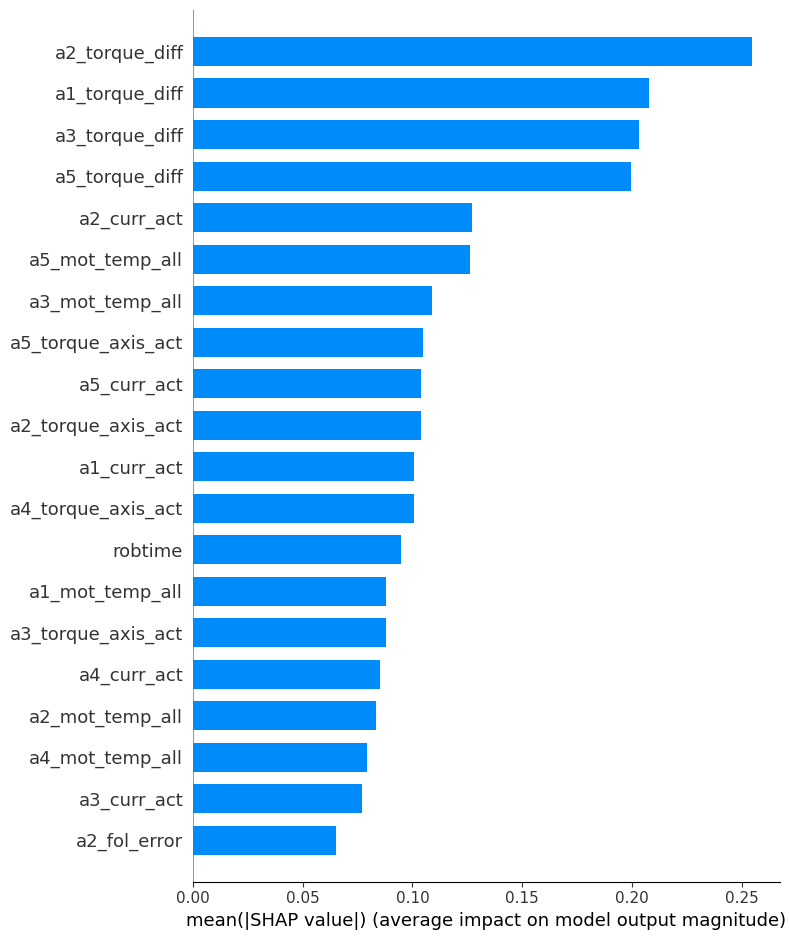

In [28]:
# visualize the global importance of features
# blue bar shows importance
# blue dots: low values
# red dots high values
# low SHAP values (left) -> anomaly
# high SHAP values (right) -> nominal
shap.summary_plot(shapvs, train, plot_type="bar", color_bar=True)


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

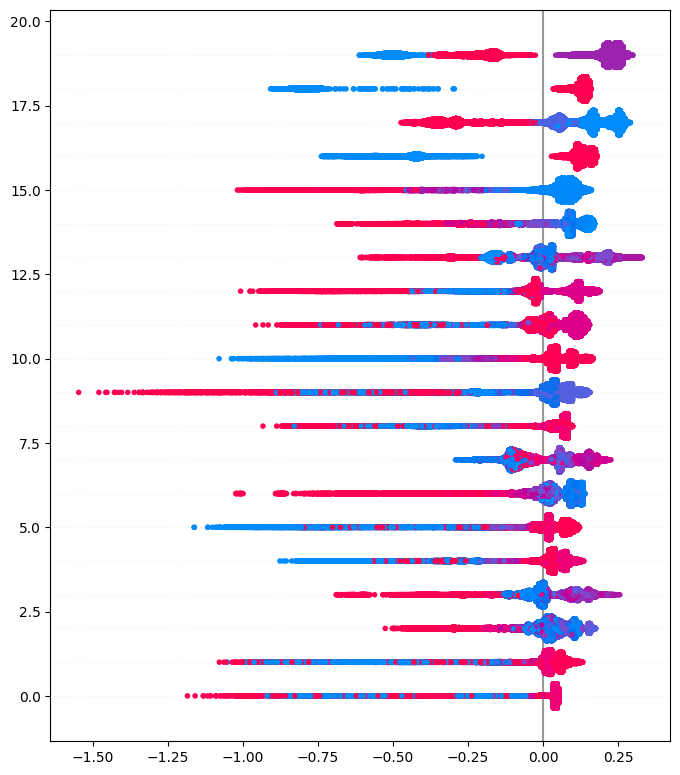

In [34]:
shap.summary_plot(shapvs, train, color_bar=True,feature_names=train.columns)


In [ ]:
# explanation for particaular point
# shows the influence of feature(s) on the predictions
idx = 1041
shap.force_plot(explainer.expected_value, shapvs[idx],features =train.iloc[idx,:] ,feature_names =test.columns)


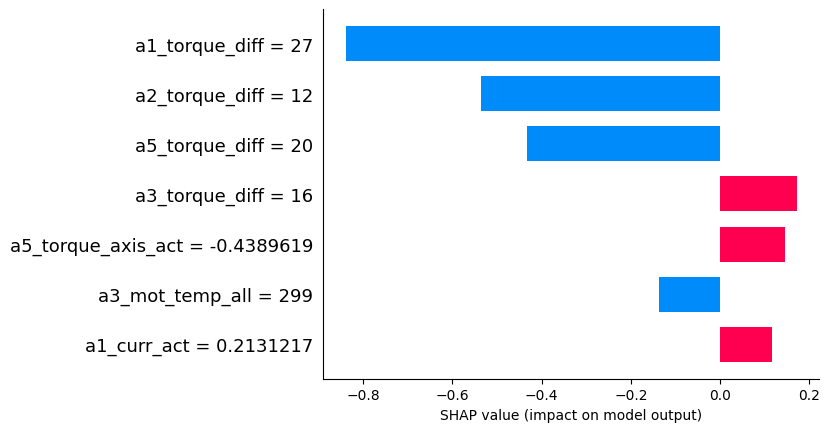

In [36]:
shap.bar_plot(shapvs[idx],features =test.iloc[idx,:] ,feature_names =test.columns )


a1, a2, a3 torque diff are pushing the outcome towards being an anomaly.
# autoencoder

In [124]:
import tensorflow as tf
from keras import layers, losses
from keras.datasets import fashion_mnist
from keras.models import Model


In [136]:
# normalize data
train_norm = (train - train.mean()) / train.std()
test_norm = (test - test.mean()) / test.std()

        a1_curr_act   a2_curr_act   a3_curr_act   a4_curr_act   a5_curr_act  \
count  8.091700e+04  8.091700e+04  8.091700e+04  8.091700e+04  8.091700e+04   
mean  -1.159109e-17 -5.057931e-17  1.404981e-17 -1.756226e-17  2.809962e-18   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -1.564684e+01 -9.505910e+00 -8.666886e+00 -1.591229e+01 -1.204042e+01   
25%   -1.098154e-01 -3.368091e-01 -1.580410e-02 -2.789929e-02 -1.279826e-01   
50%   -1.952396e-02 -2.783937e-01  1.804720e-01 -1.679403e-02 -1.178795e-01   
75%   -1.269770e-02 -2.687285e-01  1.958464e-01  3.386917e-01  3.206935e-01   
max    1.622108e+01  1.595097e+01  9.117269e+00  7.388127e+00  7.938711e+00   

       a1_fol_error  a2_fol_error  a3_fol_error  a4_fol_error  a5_fol_error  \
count  8.091700e+04  8.091700e+04  8.091700e+04  8.091700e+04  8.091700e+04   
mean   7.903017e-18  6.629754e-18 -1.756226e-19  5.795546e-18  1.789155e-18   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.

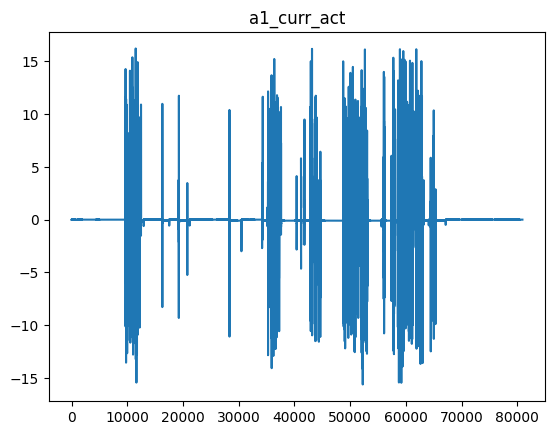

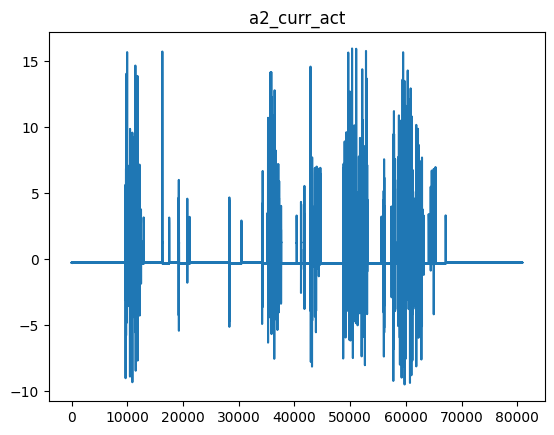

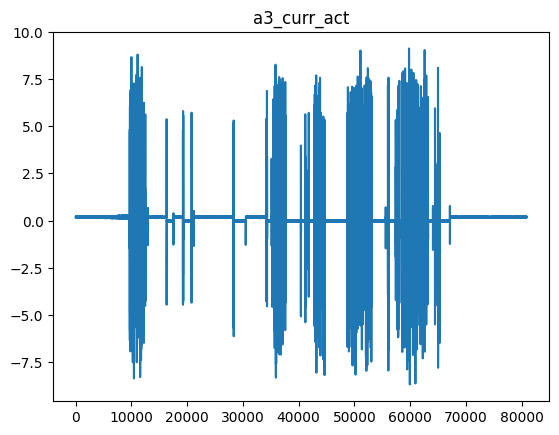

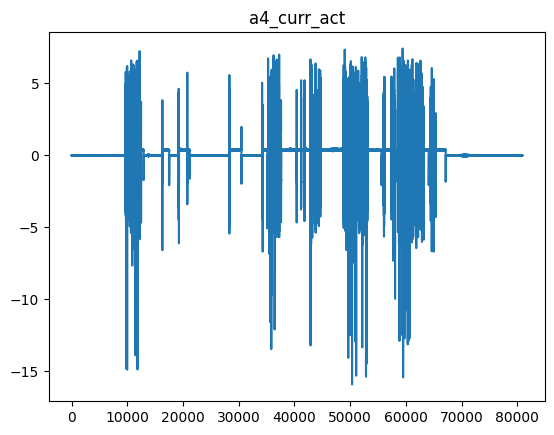

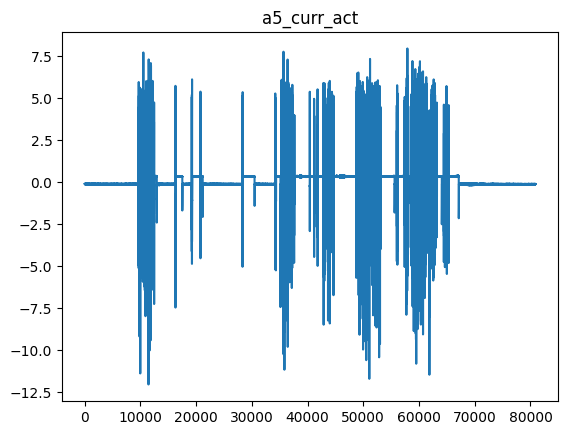

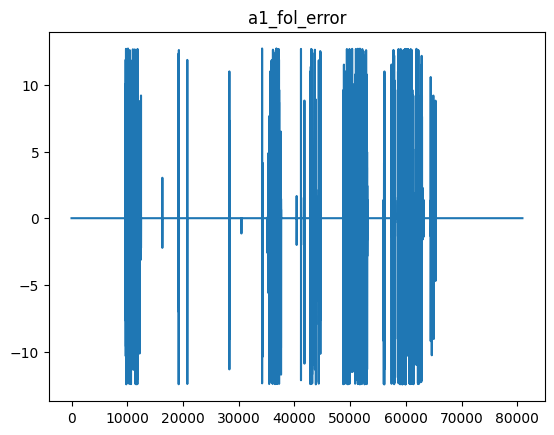

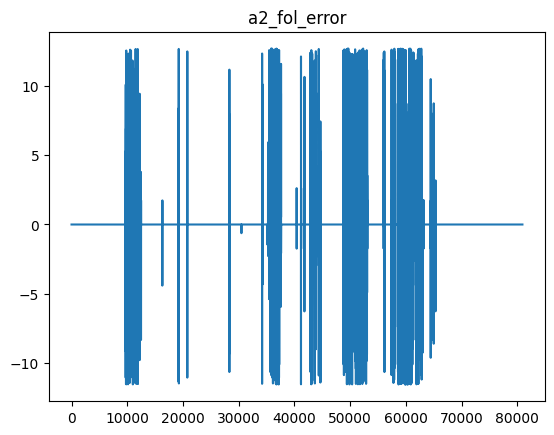

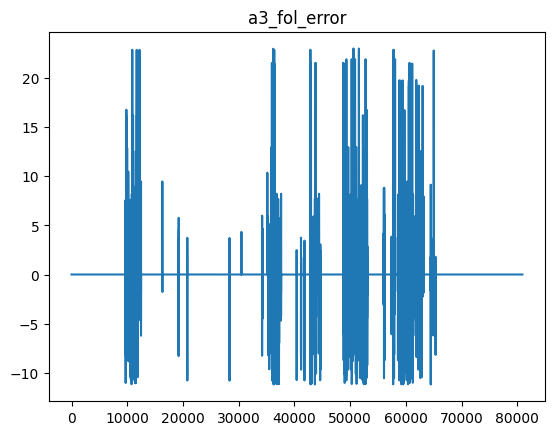

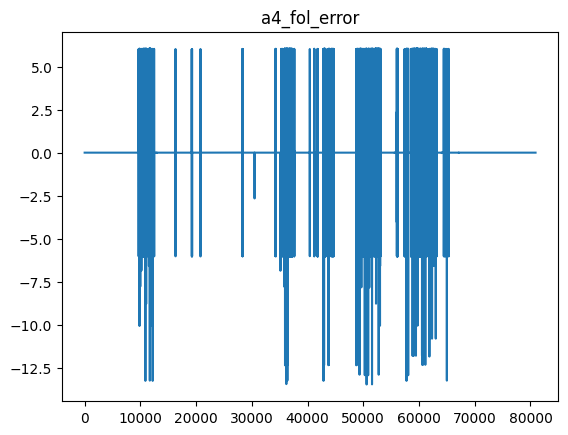

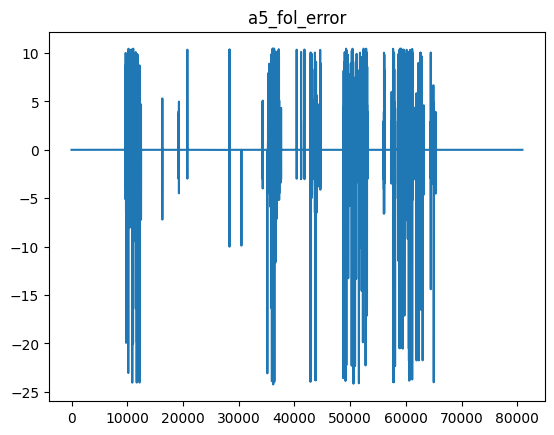

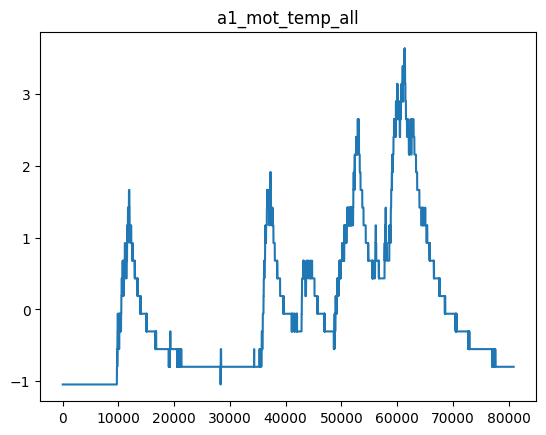

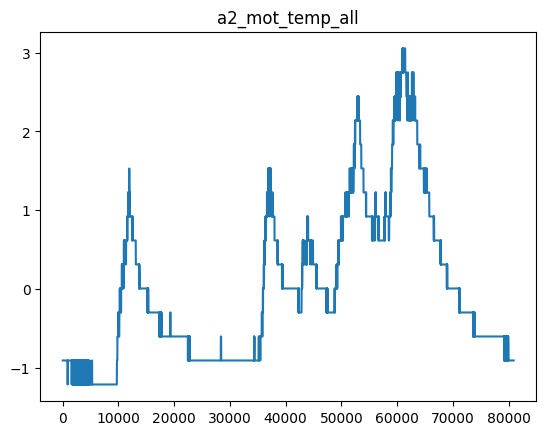

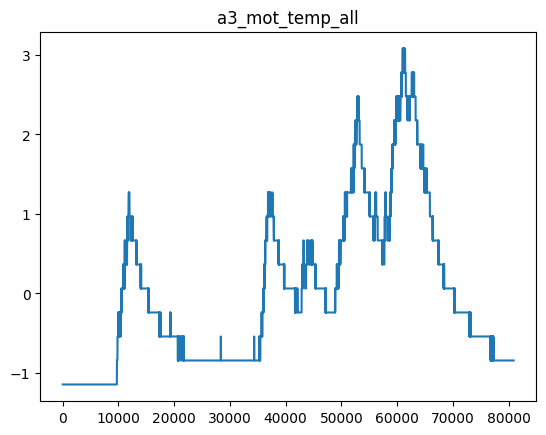

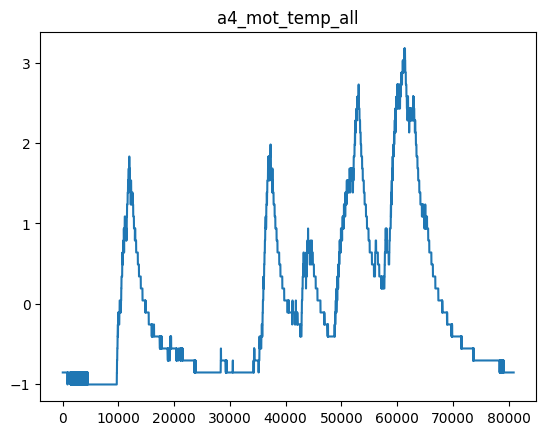

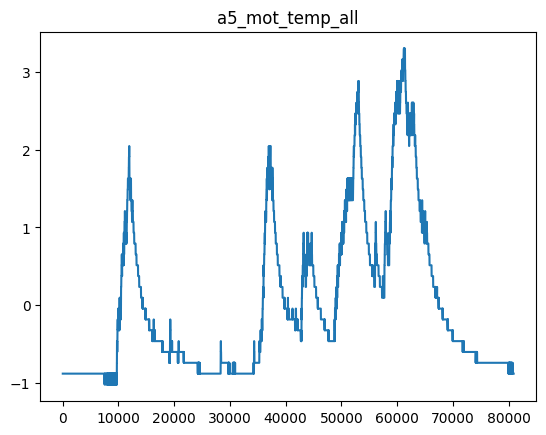

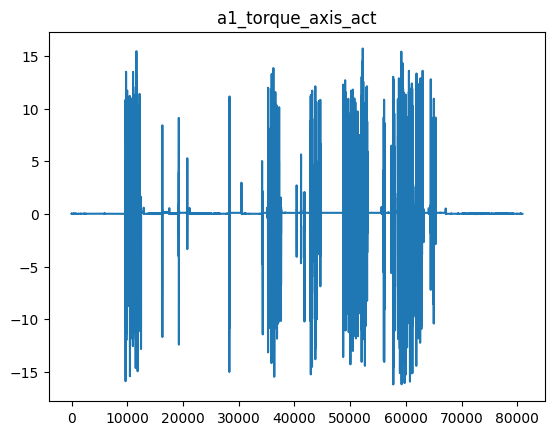

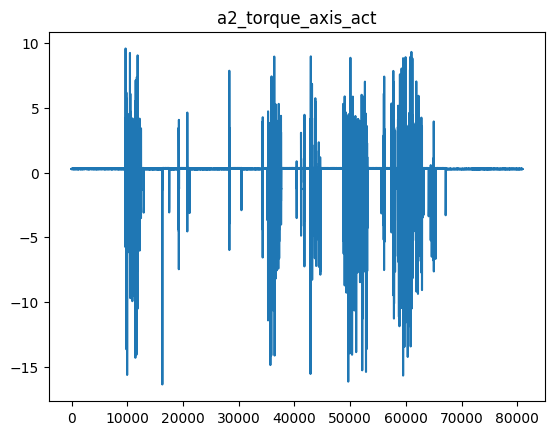

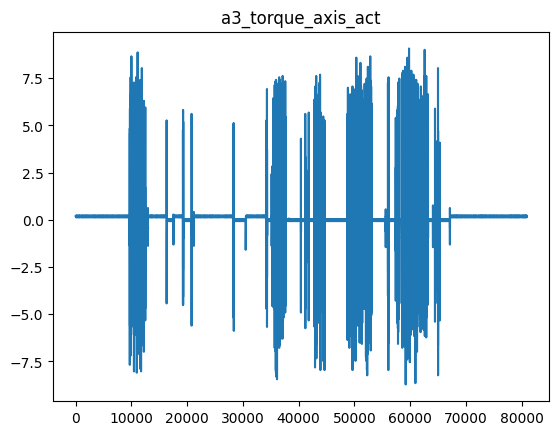

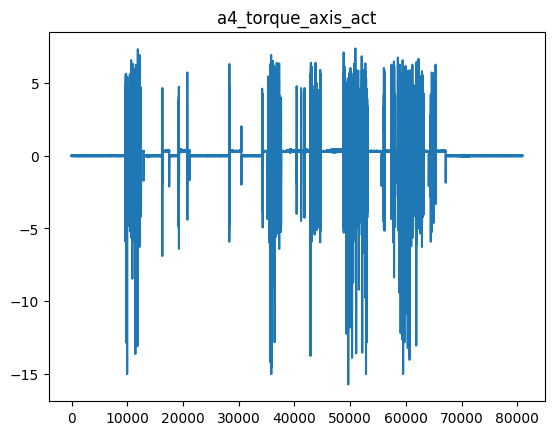

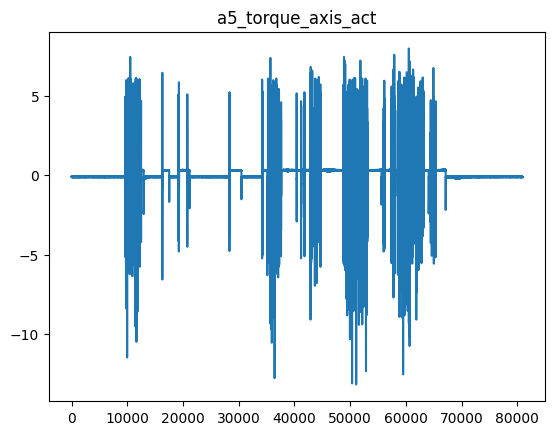

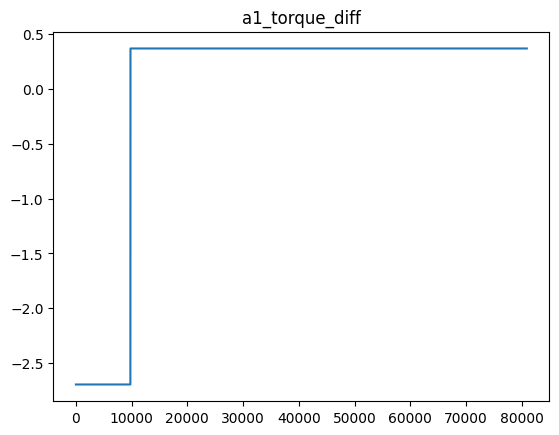

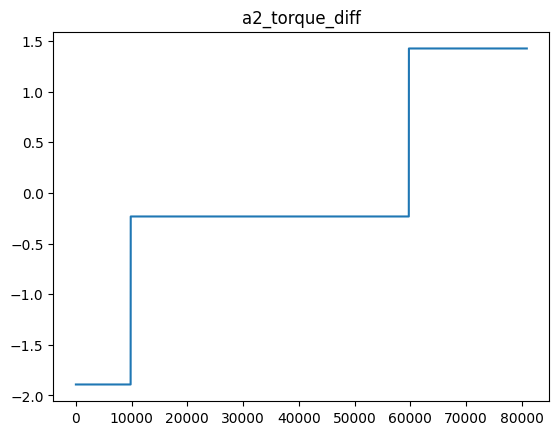

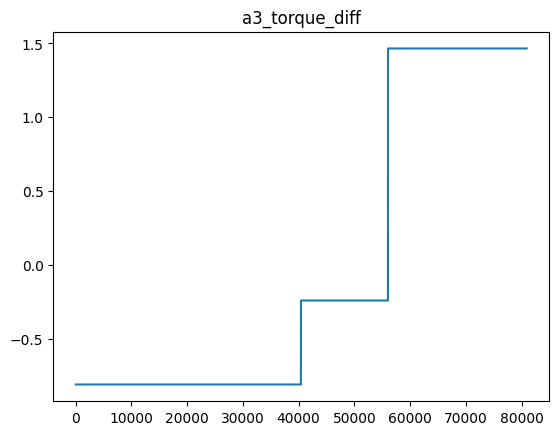

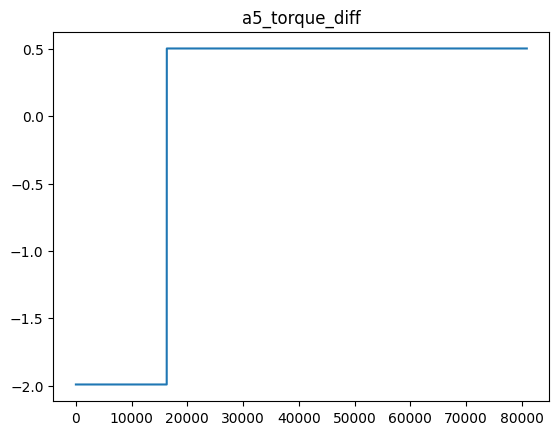

In [137]:
# check if normalization went as expected
print(train_norm.describe())
for col in test_norm.columns:
    plt.plot(test_norm[col])
    plt.title(col)
    plt.show()

In [138]:
# drop a4_torque_diff
test_norm = test_norm.drop(['a4_torque_diff'], axis=1)
train_norm = train_norm.drop(['a4_torque_diff'], axis=1)

KeyError: "['a4_torque_diff'] not found in axis"

In [152]:
# Build the model

class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(6, activation="relu"),
      layers.Dense(1, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(6, activation="relu"),
      layers.Dense(24, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()
autoencoder.compile(optimizer='adam', loss='mae')

history = autoencoder.fit(train_norm, train_norm,
          epochs=40,
          batch_size=512,
          validation_data=(test_norm, test_norm),
          shuffle=True)

Epoch 1/40
159/159 [==============================] - 1s 5ms/step - loss: 0.7195 - val_loss: 0.6460
Epoch 2/40
159/159 [==============================] - 0s 2ms/step - loss: 0.5547 - val_loss: 0.5021
Epoch 3/40
159/159 [==============================] - 0s 2ms/step - loss: 0.4887 - val_loss: 0.4796
Epoch 4/40
159/159 [==============================] - 0s 2ms/step - loss: 0.4742 - val_loss: 0.4693
Epoch 5/40
159/159 [==============================] - 0s 2ms/step - loss: 0.4655 - val_loss: 0.4618
Epoch 6/40
159/159 [==============================] - 0s 2ms/step - loss: 0.4587 - val_loss: 0.4558
Epoch 7/40
159/159 [==============================] - 0s 2ms/step - loss: 0.4534 - val_loss: 0.4510
Epoch 8/40
159/159 [==============================] - 0s 2ms/step - loss: 0.4491 - val_loss: 0.4472
Epoch 9/40
159/159 [==============================] - 0s 2ms/step - loss: 0.4455 - val_loss: 0.4438
Epoch 10/40
159/159 [==============================] - 0s 2ms/step - loss: 0.4421 - val_loss: 0.4404

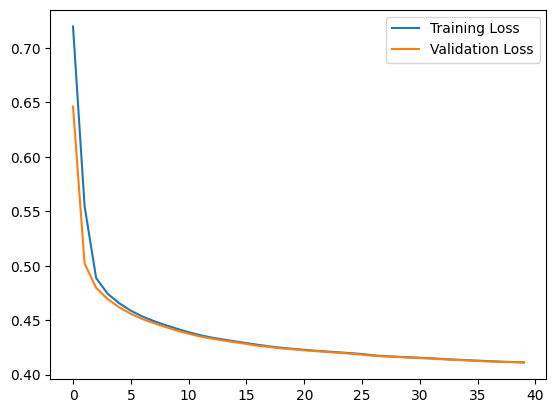

In [153]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

anomalous if the reconstruction error is greater than one standard deviation from the normal training examples.
plot normal from the training set,
the reconstruction after it's encoded and decoded by the autoencoder,
and the reconstruction error.

In [170]:
print(test_norm.values[0])
encoded_data = autoencoder.encoder(test_norm)#.numpy()
# decoded_data = autoencoder.decoder(encoded_data).numpy()

# plt.plot(test_norm.values[0], 'b')
# plt.plot(decoded_data[0], 'r')
# # plt.fill_between(np.arange(24), decoded_data[0], test_norm[0], color='lightcoral')
# # plt.legend(labels=["Input", "Reconstruction", "Error"])
# plt.show()

[-1.71327998e-02 -2.77930749e-01  1.81420277e-01 -3.03714398e-02
 -1.09606414e-01  5.59212649e-03 -3.82647500e-03  5.99992950e-03
 -6.28391280e-03  5.96120268e-04 -1.04454143e+00 -9.06147725e-01
 -1.14561254e+00 -8.59707220e-01 -8.78654604e-01  1.81775654e-02
  2.74248130e-01  2.13713404e-01  1.12711902e-02 -8.60904520e-02
 -2.69712403e+00 -1.89162228e+00 -8.10114768e-01 -1.99117888e+00]
0        -0.017133    -0.277931     0.181420    -0.030371    -0.109606   
1        -0.018328    -0.279773     0.191044    -0.011863    -0.124303   
2        -0.019012    -0.279773     0.206439    -0.015564    -0.115578   
3        -0.008259    -0.276088     0.198752    -0.014322    -0.118332   
4        -0.014745    -0.280226     0.193930     0.004187    -0.119257   
...            ...          ...          ...          ...          ...   
80912    -0.014573    -0.282069     0.196815    -0.030371    -0.131190   
80913    -0.012866    -0.277468     0.202585    -0.030371    -0.128435   
80914    -0.01355

AttributeError: Exception encountered when calling layer "sequential_32" "                 f"(type Sequential).

'tuple' object has no attribute 'rank'

Call arguments received by layer "sequential_32" "                 f"(type Sequential):
  • inputs=       a1_curr_act  a2_curr_act  a3_curr_act  a4_curr_act  a5_curr_act  \
0        -0.017133    -0.277931     0.181420    -0.030371    -0.109606   
1        -0.018328    -0.279773     0.191044    -0.011863    -0.124303   
2        -0.019012    -0.279773     0.206439    -0.015564    -0.115578   
3        -0.008259    -0.276088     0.198752    -0.014322    -0.118332   
4        -0.014745    -0.280226     0.193930     0.004187    -0.119257   
...            ...          ...          ...          ...          ...   
80912    -0.014573    -0.282069     0.196815    -0.030371    -0.131190   
80913    -0.012866    -0.277468     0.202585    -0.030371    -0.128435   
80914    -0.013550    -0.269655     0.215095    -0.021738    -0.123389   
80915    -0.010307    -0.275635     0.182389    -0.036545    -0.129360   
80916    -0.013550    -0.277468     0.201637    -0.026670    -0.119257   

       a1_fol_error  a2_fol_error  a3_fol_error  a4_fol_error  a5_fol_error  \
0          0.005592     -0.003826         0.006     -0.006284      0.000596   
1          0.005592     -0.003826         0.006     -0.006284      0.000596   
2          0.005592     -0.003826         0.006     -0.006284      0.000596   
3          0.005592     -0.003826         0.006     -0.006284      0.000596   
4          0.005592     -0.003826         0.006     -0.006284      0.000596   
...             ...           ...           ...           ...           ...   
80912      0.005592     -0.003826         0.006     -0.006284      0.000596   
80913      0.005592     -0.003826         0.006     -0.006284      0.000596   
80914      0.005592     -0.003826         0.006     -0.006284      0.000596   
80915      0.005592     -0.003826         0.006     -0.006284      0.000596   
80916      0.005592     -0.003826         0.006     -0.006284      0.000596   

       ...  a5_mot_temp_all  a1_torque_axis_act  a2_torque_axis_act  \
0      ...        -0.878655            0.018178            0.274248   
1      ...        -0.878655            0.024419            0.274248   
2      ...        -0.878655            0.024419            0.289874   
3      ...        -0.878655            0.018178            0.274248   
4      ...        -0.878655            0.011936            0.289874   
...    ...              ...                 ...                 ...   
80912  ...        -0.878655            0.018178            0.258622   
80913  ...        -0.878655            0.011936            0.274248   
80914  ...        -0.878655            0.018178            0.289874   
80915  ...        -0.878655            0.018178            0.258622   
80916  ...        -0.878655            0.011936            0.274248   

       a3_torque_axis_act  a4_torque_axis_act  a5_torque_axis_act  \
0                0.213713            0.011271           -0.086090   
1                0.213713            0.011271           -0.119318   
2                0.213713           -0.033316           -0.086090   
3                0.213713            0.011271           -0.086090   
4                0.213713           -0.033316           -0.119318   
...                   ...                 ...                 ...   
80912            0.144439            0.011271           -0.119318   
80913            0.213713            0.011271           -0.119318   
80914            0.213713           -0.033316           -0.119318   
80915            0.144439            0.011271           -0.086090   
80916            0.213713            0.011271           -0.119318   

       a1_torque_diff  a2_torque_diff  a3_torque_diff  a5_torque_diff  
0           -2.697124       -1.891622       -0.810115       -1.991179  
1           -2.697124       -1.891622       -0.810115       -1.991179  
2           -2.697124       -1.891622       -0.810115       -1.991179  
3           -2.697124       -1.891622       -0.810115       -1.991179  
4           -2.697124       -1.891622       -0.810115       -1.991179  
...               ...             ...             ...             ...  
80912        0.370761        1.426164        1.465821        0.502209  
80913        0.370761        1.426164        1.465821        0.502209  
80914        0.370761        1.426164        1.465821        0.502209  
80915        0.370761        1.426164        1.465821        0.502209  
80916        0.370761        1.426164        1.465821        0.502209  

[80917 rows x 24 columns]
  • training=None
  • mask=None

2529/2529 [==============================] - 2s 611us/step


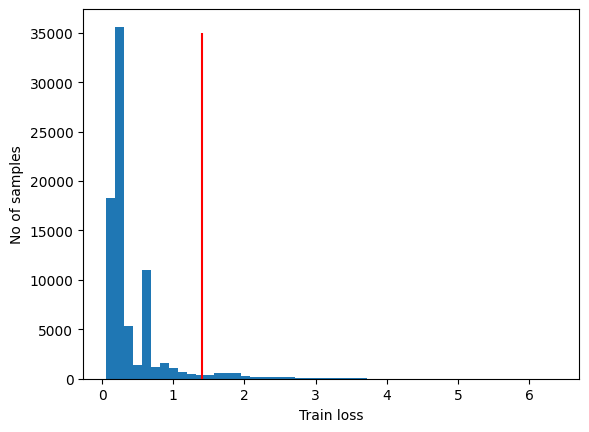

In [191]:
reconstructions = autoencoder.predict(train_norm)
train_loss = tf.keras.losses.mae(reconstructions, train_norm)
threshold = 1.4
plt.hist(train_loss[None,:], bins=50)
plt.vlines(threshold, ymin=0, ymax=35000, colors="r", zorder=100, label='Threshold')

plt.xlabel("Train loss")
plt.ylabel("No of samples")
plt.show()

In [187]:
reconstructions = autoencoder.predict(test_norm)
loss = tf.keras.losses.mae(reconstructions, test_norm)
prediction_autoencoder = tf.math.less(loss, threshold)
# print number of true in prediction
print(prediction_autoencoder.numpy().sum())
print('fraq of anomalies in test data: {}'.format(1-prediction_autoencoder1.numpy().sum()/len(test)))


2529/2529 [==============================] - 2s 601us/step
77025
fraq of anomalies in test data: 0.04809866900651283


In [188]:
# compare isolation forest with autoencoder
# create new variable prediction_isolationforest with True for anomalies and False for normal
prediction_isolationforest = []
for i in isofor_score:
    if i <0:
        prediction_isolationforest.append(True)
    else:
        prediction_isolationforest.append(False)
print(len(prediction_isolationforest))

80917


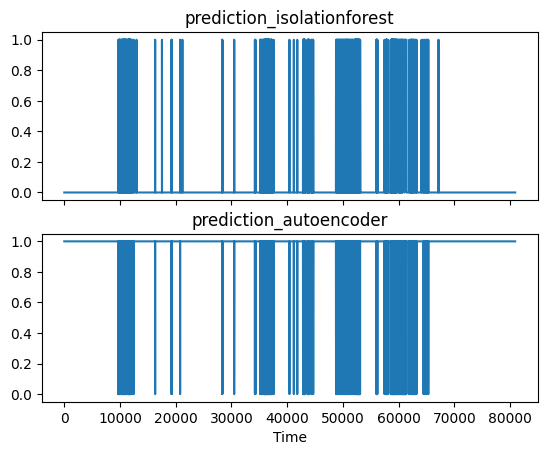

In [190]:
# plot isofor_score_binary and prediction as subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(prediction_isolationforest)
ax1.set_title('prediction_isolationforest')
ax2.plot(prediction_autoencoder)
ax2.set_title('prediction_autoencoder')
plt.xlabel("Time")
plt.show()